**Brian Blaylock**  
**September 6, 2019**

# Look at `glmtool` output

In [294]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3')
from BB_GOES.get_ABI import file_nearest
from BB_GOES.get_GOES import get_GOES_nearesttime
from BB_GOES.get_GLM import accumulate_GLM_FAST
from BB_maps.my_basemap import draw_HRRR_map, draw_centermap
from BB_HRRR.GLM_and_HRRR.GLM_events_HRRR import get_GLM_HRRR_contingency_stats
from BB_HRRR.HRRR_Pando import get_hrrr_latlon

In [297]:
HRRRlat, HRRRlon = get_hrrr_latlon(DICT=False)

In [242]:
m = draw_HRRR_map()

loaded /uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v3/BB_maps/saved_map_objects/HRRR_lcc_i_2000.npy map from file


In [287]:
mU = draw_centermap('Utah')

In [223]:
abi = file_nearest(datetime(2018, 6, 6))
abi = xarray.open_dataset(abi)

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/50m/physical/ne_50m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


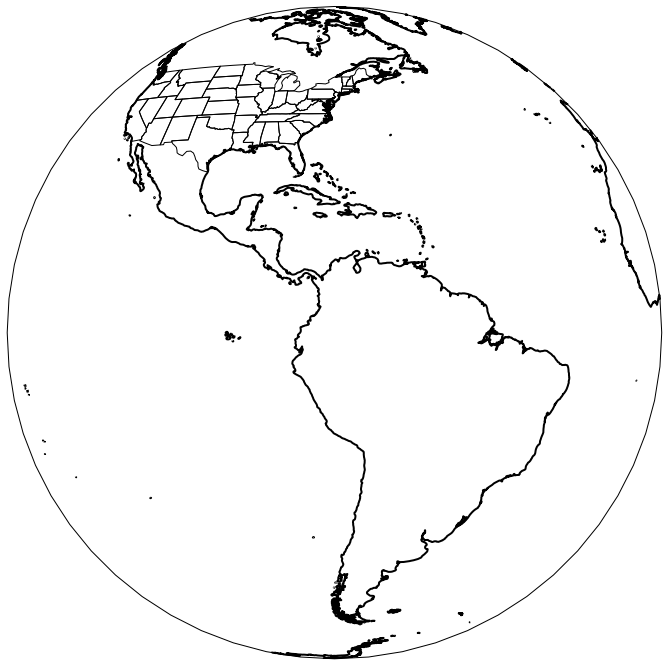

In [227]:
# Make map object
# Satellite height
sat_h = abi['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = abi['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = abi['goes_imager_projection'].sweep_angle_axis

semi_major = abi['goes_imager_projection'].semi_major_axis
semi_minor = abi['goes_imager_projection'].semi_minor_axis

# The projection x and y coordinates equals the scanning angle (in radians)
# multiplied by the satellite height See details here:
# https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = abi['x'][:] * sat_h
y = abi['y'][:] * sat_h

fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

In [195]:
# the file ending in 'source.nc' is the event density

foot = '~/temp/2018/Jul/02/GLM-00-00_20180702_043300_20_1src_056urad-dx_source.nc'

glm = xarray.open_dataset(foot)

In [196]:
glm

<xarray.Dataset>
Dimensions:                 (ntimes: 1, nx: 2499, ny: 1499)
Dimensions without coordinates: ntimes, nx, ny
Data variables:
    goes_imager_projection  int32 ...
    x                       (nx) float32 ...
    y                       (ny) float32 ...
    time                    (ntimes) datetime64[ns] ...
    event_density           (ntimes, nx, ny) float32 ...

In [197]:
x_1d = glm.x
y_1d = glm.y

In [198]:
from lmatools.grid.fixed import get_GOESR_coordsys

In [199]:
x,y = np.meshgrid(x_1d, y_1d) # Two 2D arrays of fixed grid coordinates

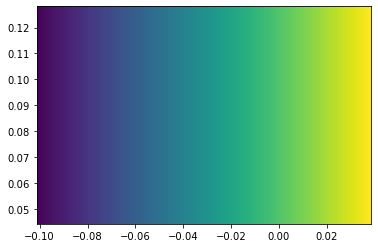

In [200]:
plt.pcolormesh(x, y, x)

In [201]:
nadir = -75.0
geofixCS, grs80lla = get_GOESR_coordsys(nadir)

In [202]:
z=np.zeros_like(x)
lon,lat,alt=grs80lla.fromECEF(*geofixCS.toECEF(x,y,z))
lon.shape = x.shape
lat.shape = y.shape

In [203]:
np.shape(lon), np.shape(lat)

((1499, 2499), (1499, 2499))

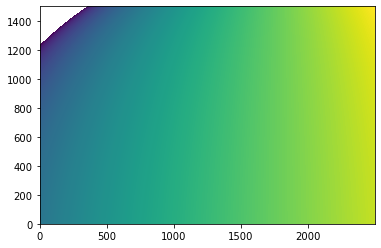

In [204]:
plt.pcolormesh(lon)

In [205]:
# change infinite locations to a point in the gulf of Alaska
lon[lon==np.inf] = -150
lat[lat==np.inf] = 55

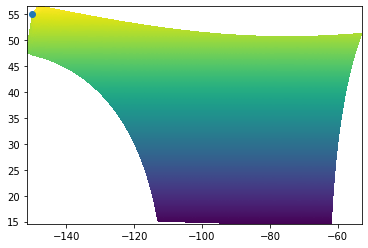

In [206]:
plt.pcolormesh(lon, lat, lat)
plt.scatter(-150, 55)

In [207]:
np.shape(glm.event_density)

(1, 2499, 1499)

In [208]:
np.shape(x)

(1499, 2499)

In [209]:
events = glm.event_density[0]

In [210]:
np.shape(events.T)

(1499, 2499)

In [160]:
np.shape(lon)

(1499, 2499)

In [238]:
np.rot90(events).shape

(1499, 2499)

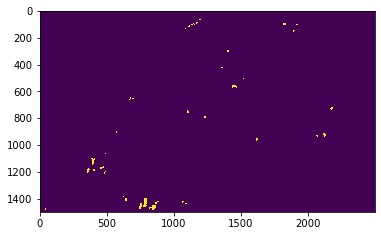

In [239]:
plt.imshow(np.rot90(events)>0)

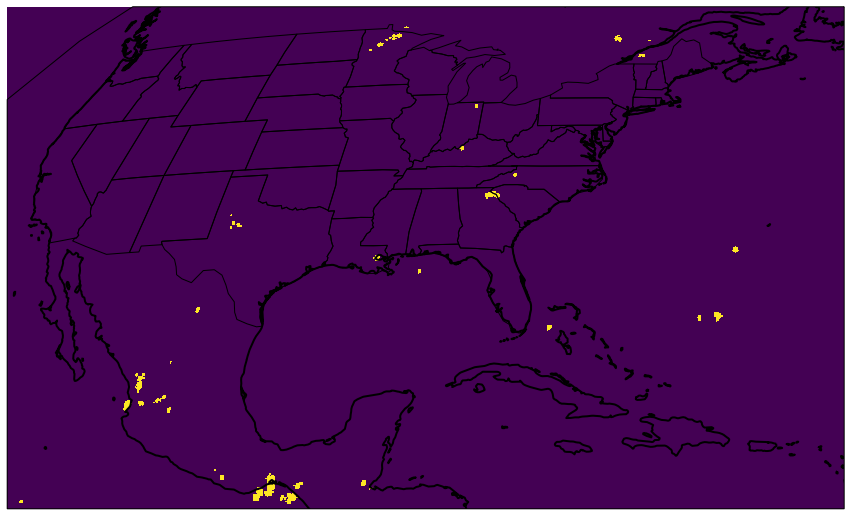

In [240]:
fig = plt.figure(figsize=(15, 12))

globe = ccrs.Globe(semimajor_axis=semi_major, semiminor_axis=semi_minor)
geos = ccrs.Geostationary(central_longitude=sat_lon, 
                         satellite_height=sat_h, globe=globe)

ax = fig.add_subplot(1, 1, 1, projection=geos)

ax.imshow(np.rot90(events)>0, origin='upper',
                   extent=(x.min(), x.max(), y.min(), y.max()),
                   transform=geos,
                   interpolation='nearest')
ax.coastlines(resolution='50m', color='black', linewidth=2)
ax.add_feature(ccrs.cartopy.feature.STATES)

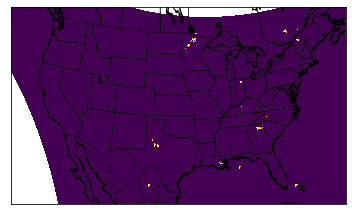

In [249]:
m.pcolormesh(lon, lat, events.T>0, latlon=True)

m.drawcoastlines(); m.drawcountries(); m.drawstates()

In [110]:
path = '~/temp/2018/Jul/02/'
types = ['flash_extent', \
         'flash_init', \
         'footprint', \
         'group_area', \
         'group_extent', \
         'group_init', \
         'source', \
         'total_energy']


In [112]:
for i in types:
    file = path+'GLM-00-00_20180702_043300_20_1src_056urad-dx_{}.nc'.format(i)
    glm = xarray.open_dataset(file)
    print(glm)
    print(); print()

<xarray.Dataset>
Dimensions:                 (ntimes: 1, nx: 2499, ny: 1499)
Dimensions without coordinates: ntimes, nx, ny
Data variables:
    goes_imager_projection  int32 ...
    x                       (nx) float32 ...
    y                       (ny) float32 ...
    time                    (ntimes) datetime64[ns] ...
    flash_extent_density    (ntimes, nx, ny) float32 ...


<xarray.Dataset>
Dimensions:                 (ntimes: 1, nx: 2499, ny: 1499)
Dimensions without coordinates: ntimes, nx, ny
Data variables:
    goes_imager_projection  int32 ...
    x                       (nx) float32 ...
    y                       (ny) float32 ...
    time                    (ntimes) datetime64[ns] ...
    flash_centroid_density  (ntimes, nx, ny) float32 ...


<xarray.Dataset>
Dimensions:                 (ntimes: 1, nx: 2499, ny: 1499)
Dimensions without coordinates: ntimes, nx, ny
Data variables:
    goes_imager_projection  int32 ...
    x                       (nx) float32 ...
    y      

# Case studies

In [255]:
utah_DATE = datetime(2018, 7, 17, 6)
utah_glm = get_GOES_nearesttime(utah_DATE-timedelta(minutes=30),
                                product='GLM', satellite=16, window=30)

Requested 2018-07-17 05:30:00	satellite: GOES-16	Product: GLM
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/04/
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/
Looking here: /uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/06/
---------------------------------------------------
 Window == +/- 30 Minutes
    first observation: 2018-07-17 05:00:00
     last observation: 2018-07-17 06:00:00
  Returning data from 180 GLM files (expected 180)
---------------------------------------------------


In [256]:
utah_glm

{'Files': array(['/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980500000_e20181980500200_c20181980500224.nc',
        '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980500200_e20181980500400_c20181980500423.nc',
        '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980500400_e20181980501000_c20181980501024.nc',
        '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980501000_e20181980501200_c20181980501227.nc',
        '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980501200_e20181980501400_c20181980501424.nc',
        '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/GLM-L2-LCFA/20180717/05/OR_GLM-L2-LCFA_G16_s20181980501400_e20181980502000_c20181980502024.nc',
        '/uuf

In [257]:
from shutil import copyfile

In [266]:
for f in utah_glm['Files']:
    name = f.split('/')[-1]
    copyfile(f, '/uufs/chpc.utah.edu/common/home/u0553130/temp/'+name)

# Utah Thunderstorm Case

In [273]:
UTstorm = xarray.open_dataset('~/temp/2018/Jul/17/GLM-00-00_20180717_050000_3600_1src_056urad-dx_source.nc')

In [274]:
UTstorm

<xarray.Dataset>
Dimensions:                 (ntimes: 60, nx: 2499, ny: 1499)
Dimensions without coordinates: ntimes, nx, ny
Data variables:
    goes_imager_projection  int32 ...
    x                       (nx) float32 ...
    y                       (ny) float32 ...
    time                    (ntimes) datetime64[ns] ...
    event_density           (ntimes, nx, ny) float32 ...

In [275]:
UTstorm.time

<xarray.DataArray 'time' (ntimes: 60)>
array(['2018-07-17T05:00:00.000000000', '2018-07-17T05:01:00.000000000',
       '2018-07-17T05:02:00.000000000', '2018-07-17T05:03:00.000000000',
       '2018-07-17T05:04:00.000000000', '2018-07-17T05:05:00.000000000',
       '2018-07-17T05:06:00.000000000', '2018-07-17T05:07:00.000000000',
       '2018-07-17T05:08:00.000000000', '2018-07-17T05:09:00.000000000',
       '2018-07-17T05:10:00.000000000', '2018-07-17T05:11:00.000000000',
       '2018-07-17T05:12:00.000000000', '2018-07-17T05:13:00.000000000',
       '2018-07-17T05:14:00.000000000', '2018-07-17T05:15:00.000000000',
       '2018-07-17T05:16:00.000000000', '2018-07-17T05:17:00.000000000',
       '2018-07-17T05:18:00.000000000', '2018-07-17T05:19:00.000000000',
       '2018-07-17T05:20:00.000000000', '2018-07-17T05:21:00.000000000',
       '2018-07-17T05:22:00.000000000', '2018-07-17T05:23:00.000000000',
       '2018-07-17T05:24:00.000000000', '2018-07-17T05:25:00.000000000',
       '2018

In [320]:
hr_binary = np.sum(UTstorm.event_density, axis=0)>1

In [321]:
np.shape(hr_binary.T)

(1499, 2499)

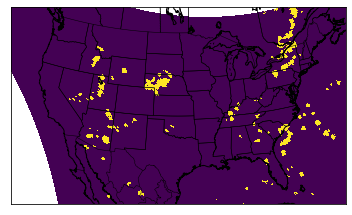

In [322]:
m.pcolormesh(lon, lat, hr_binary.T, latlon=True)

m.drawcoastlines(); m.drawcountries(); m.drawstates()

In [323]:
# Get data from previously calculated binary field
obs_binary = get_GLM_HRRR_contingency_stats(utah_date, fxx=range(1,19), GOES=16, verbose=True)['Observed Binary']

>>> get_GLM_HRRR_contingency_stats: 2018-07-17 06:00:00
>>Load binary stats from file /uufs/chpc.utah.edu/common/home/horel-group8/blaylock/GLM-HRRR_LTNG_binary//HRRR-GLM-Binary_2018-07-17_0600.npy


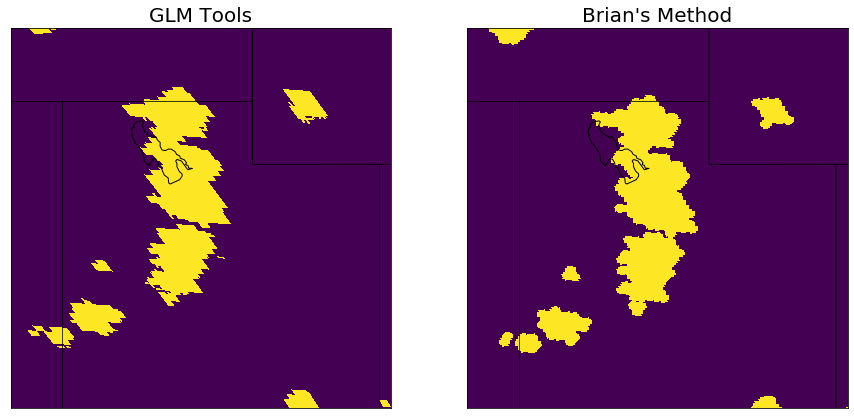

In [326]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

plt.sca(ax1)
plt.title('GLM Tools', fontsize=20)
mU.pcolormesh(lon, lat, hr_binary.T, latlon=True)
mU.drawcoastlines(); mU.drawcountries(); mU.drawstates()

plt.sca(ax2)
plt.title("Brian's Method", fontsize=20)
mU.pcolormesh(HRRRlon, HRRRlat, obs_binary, latlon=True)
mU.drawcoastlines(); mU.drawcountries(); mU.drawstates()

/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: No contour levels were found within the data range.
  
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: The following kwargs were not used by contour: 'label'
  
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: No contour levels were found within the data range.
  import sys
/uufs/chpc.utah.edu/common/home/u0553130/anaconda3/envs/pyBKB_v3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys


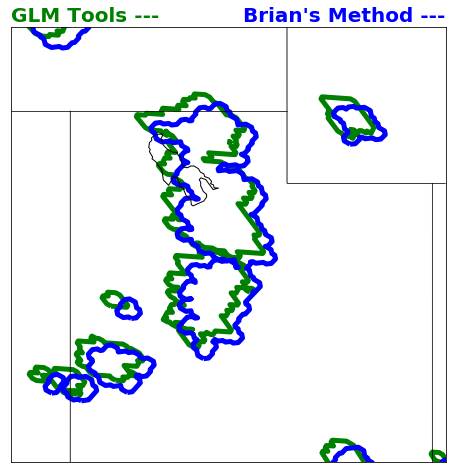

In [327]:
fig, ax1 = plt.subplots(1,1, figsize=(8,8))

plt.sca(ax1)
plt.title('GLM Tools ---', color='green', fontsize=20, fontweight='bold', loc='left')
plt.title("Brian's Method ---", color='blue', fontsize=20, fontweight='bold', loc='right')
mU.contour(lon, lat, hr_binary.T, latlon=True, levels=[0,1], colors='green', linewidths=5, label="GLM Tools")
mU.contour(HRRRlon, HRRRlat, obs_binary, latlon=True, levels=[0,1], colors='b', linewidths=5, label="Brian's Invention")
mU.drawcoastlines(); mU.drawcountries(); mU.drawstates()
